In [72]:
# def summate_points(xp):
#     return np.sum(xp)

# def get_Z(xp2, yp2):
#     size = len(xp2)
#     Z = 0
#     for i in range(size):
#         Z += xp2[i]**2 + yp2[i]**2   
#     return Z

# def get_W(xp):
#     return len(xp)

# def get_C1(xp1,yp1,xp2,yp2):
#     size = len(xp1)
#     C = 0 
#     for i in range(size):
#         C += xp1[i]*xp2[i] + yp1[i]*yp2[i] 
#     return C

# def get_C2(xp1,yp1,xp2,yp2):
#     size = len(xp1)
#     C = 0
#     for i in range(size):
#         C += yp1[i]*xp2[i] - xp1[i]*yp2[i]  
#     return C

# def get_new_pose_param(P1, P2):
#     xp1,yp1 = P1.transpose()
#     xp2,yp2 = P2.transpose()
    
#     X1,X2,Y1,Y2 = np.sum(xp1), np.sum(xp2), np.sum(yp1), np.sum(yp2)
#     Z = get_Z(xp2, yp2)
#     W = get_W(xp1)
#     C1 = get_C1(xp1,yp1,xp2,yp2)
#     C2 = get_C2(xp1,yp1,xp2,yp2)
    
#     m = np.array([[X2,Y2,Z,0],[-Y2,X2,0,Z],[W,0,X2,-Y2],[0,W,Y2,X2]])
#     y = np.array([X1,Y1,C1,C2])
    
#     (ax, ay, tx, ty) = np.linalg.lstsq(m, y)[0]
    
#     # ax = s*cos(angle)  ;  ay = s*sin(angle)
#     return (ax, ay, tx, ty)

# def transform(p, pose_param):
#     Txy, scale, rad = pose_param
#     rotation = np.array([[math.cos(rad), -math.sin(rad)],[ math.sin(rad), math.cos(rad)]])
#     return Txy + np.dot(s*rotation, p)
# def inv_transform(p, pose_param):
#     Txy, scale, rad = pose_param
#     rotation = np.array([[math.cos(rad), math.sin(rad)],[ -math.sin(rad), math.cos(rad)]])
#     return np.dot(rotation/s, p-Txy)

In [11]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import FileManager
import PCA_analysis
import random

import math
import sklearn


# test setting
def test_transformations():

    a = np.array([[-1,1],[1,1],[1,-1],[-1,-1]])
    FileManager.show_tooth_points(a)
    b = np.array([[1,6],[6,6],[6,1],[1,1]])
    FileManager.show_tooth_points(b)

    ay = math.sin(math.pi/6)
    ax = math.cos(math.pi/6)
    c = transform(a,(ax,ay,1,0))
    FileManager.show_tooth_points(c)
    
    pose_param = get_pose_param_for_transformation(a, b)
    y = transform(a,pose_param)
    FileManager.show_tooth_points(y)
    
    pose_param = get_pose_param_for_transformation(a, c)
    z = transform(a,pose_param)
    FileManager.show_tooth_points(z)


def get_range_of(i, pca):
    eigenvalues = PCA_analysis.get_eigenvalues(pca)
    bound = 3*math.sqrt(eigenvalues[i])
    return bound

def constraint_model_param(b,pca):
    
    for i in range(len(b)):
        bound = get_range_of(i,pca)
        if( b[i] > bound):
            b[i] = bound
        elif ( b[i] < -bound):
            b[i] = -bound
    return b

def generate_model_point(b, pca):
    eigenvectors = PCA_analysis.get_eigenvectors(pca)
    P = eigenvectors.transpose()
    #b = get_eigenvalues(pca)
    xm = PCA_analysis.get_mean(pca)
    
    x =  np.dot(P,b)
    return x + xm

def update_model_param(y, pca):
    xm = pca.mean_
    PT = PCA_analysis.get_eigenvectors(pca)
    return np.dot(PT, y.reshape(-1) - xm)

def get_pose_param_for_transformation(A,B):
    
    s = round(len(A)/3)
    r = random.randint(0, s) 
    r2 , r3 = round(r+s), round(r+2*s)
    
    pts1 = np.float32((A[r],A[r2],A[r3]))
    pts2 = np.float32((B[r],B[r2],B[r3]))
    M = cv2.getAffineTransform(pts1,pts2)
    
    ax, ay, tx, ty = M[0,0], M[1,0], M[0,2], M[1,2]
    return (ax, ay, tx, ty)

def transform(p, pose_param):
    (ax, ay, tx, ty) = pose_param
    scale_rotation = np.array([[ax, -ay],[ ay, ax]])
    Txy = np.array([tx, ty])
    
    p_transformed = np.dot(scale_rotation, p.transpose()) 
    return (np.add(Txy, p_transformed.transpose()))

def inv_transform(p, pose_param):
    (ax, ay, tx, ty) = pose_param
    scale_rotation = np.array([[ax, ay],[ -ay, ax]])
    divisor = 1 / (ax**2 + ay**2)
    Txy = np.array([tx, ty])
    transformed = np.dot(scale_rotation*divisor, np.transpose(p-Txy))
    return transformed.transpose()

def project_to_tangent_plane(y, pca):
    xm = pca.mean_
    y = y.reshape(-1)
    return y / np.dot(y,xm)


#protocol 1
def match_model_points(Y, pca):
    b = np.zeros(len(pca.components_)) 

    max_conv_iter = 20
    best_b = b
    best_pose_param = (0,0,0,0)
    best_MSE = np.inf
    convergence_iter = max_conv_iter

    while(1):
        
        x = generate_model_point(b, pca)
        x = x.reshape(40,2)
        pose_param = get_pose_param_for_transformation(Y,x)
        
        Y_pred = inv_transform(x,pose_param)
        MSE = sklearn.metrics.mean_squared_error(Y, Y_pred)
        
        if(MSE < best_MSE):
            best_b = b
            best_pose_param = pose_param
            best_MSE = MSE
            convergence_iter = max_conv_iter
        
        convergence_iter -= 1
        if(convergence_iter == 0 or best_MSE < 1):
            #print(convergence_iter, best_MSE)
            break;    
         
        y = transform(Y,pose_param)
        
        y = project_to_tangent_plane(y, pca)
        y = y.reshape(40,2)

        b = update_model_param(y, pca)
        b = constraint_model_param(b,pca)

    return best_b, best_pose_param;

def show_tooth_points(landmark, show=True, color = 'red'):
    plt.plot(landmark[:,0], landmark[:,1], 'ro',color=color)
    
    if show:
        plt.show()
        
def show_matching_of_teeth():
    
    plt.figure()
    hn = 4
    fig, ax = plt.subplots(figsize=(15, 7))

    for i in range(8):
        tooth, y = test_matching(i)
        plt.subplot(2, hn, i+1)
        plt.xticks(())
        plt.yticks(())   
        show_tooth_points(y, False, 'blue')
        show_tooth_points(tooth, False, 'orange')
     
    plt.show()
    
def plot_eigenvalues():
    all_tooth_variations = landmarks[:,0]
    pca = PCA_analysis.PCA_analysis(all_tooth_variations, None)
    eigenvalues = PCA_analysis.get_eigenvalues(pca)
    x = np.zeros(14)
    for i in range(14):
        x[i] = eigenvalues[i]
    plt.plot(range(14), x)
    plt.title('Influence of eigenvalues')
    plt.xlabel('n-th principal component')
    plt.ylabel('Eigenvalue')
    plt.show()
    
def show_tooth_variatins(toothID, pcaID, size):
    landmarks = FileManager.load_landmarks_std()
    all_tooth_variations = landmarks[:,toothID]
    pca = PCA_analysis.PCA_analysis(all_tooth_variations, None)
    b = np.zeros(14)
    pca1 = get_range_of(pcaID, pca)
    b[pcaID] = pca1*size
    x = generate_model_point(b, pca)
    return x.reshape(40,2)

    
def show_tooth_variations(pcaID, size, show=True):
    x = show_tooth_variatins(0, pcaID, size)
    show_tooth_points(x ,False, 'orange')
    x = show_tooth_variatins(0, pcaID, 0)
    show_tooth_points(x ,False, 'red')
    x = show_tooth_variatins(0, pcaID, -size)
    show_tooth_points(x ,show, 'blue')

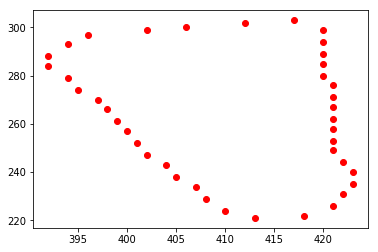

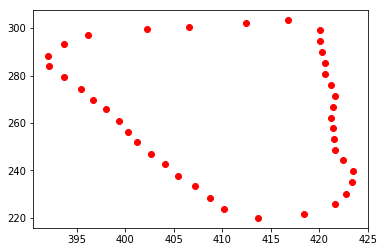

In [3]:
if __name__ == "__main__":
    teeth = np.load('initial_position.npy')
    tooth = teeth[0,0]
    
    landmarks = FileManager.load_landmarks_std()
    all_tooth_variations = landmarks[:,0]
    
    FileManager.show_tooth_points(tooth)
    pca = PCA_analysis.PCA_analysis(all_tooth_variations, None)
    
    b, pose_param = match_model_points(tooth, pca)
    
    x = generate_model_point(b, pca)
    y = inv_transform(x.reshape(40,2),pose_param)
    FileManager.show_tooth_points(y)
    
# print(tooth - y)


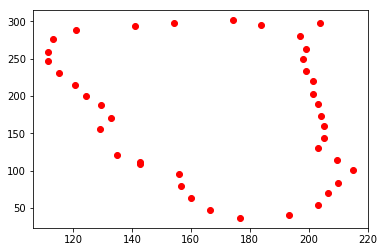

In [8]:
    fitted = np.load('fitted_tooth.npy')
    tooth = fitted[0]
    FileManager.show_tooth_points(tooth)

In [73]:
def test_matching(i=0):
    fitted = np.load('fitted_tooth.npy')
    tooth = fitted[i]
    all_tooth_variations = landmarks[:,i]
    pca = PCA_analysis.PCA_analysis(all_tooth_variations, None)
    
    b, pose_param = match_model_points(tooth, pca) 
    x = generate_model_point(b, pca)
    y = inv_transform(x.reshape(40,2),pose_param)
    return tooth, y

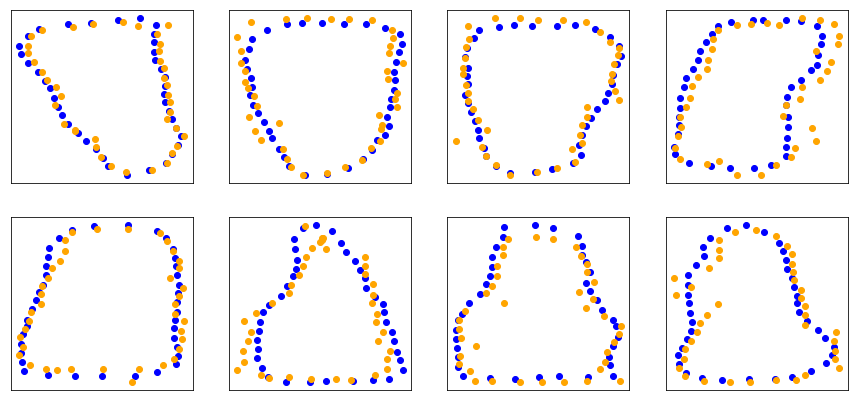

In [109]:
show_teeth_points()

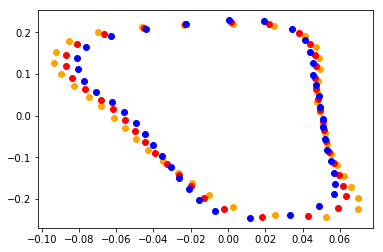

In [137]:
x = show_tooth_variatins(0, 1, 1/3)
show_tooth_points(x ,False, 'orange')
x = show_tooth_variatins(0, 1, 0)
show_tooth_points(x ,False, 'red')
x = show_tooth_variatins(0, 1, -1/3)
show_tooth_points(x ,True, 'blue')

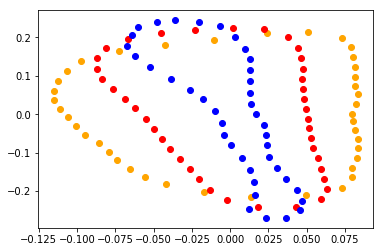

In [139]:
show_tooth_variations(0, 1)

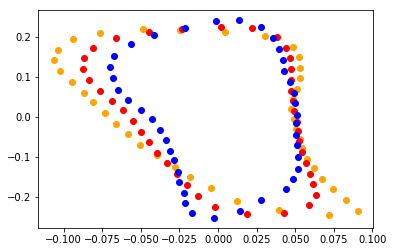

In [140]:
show_tooth_variations(1, 1)

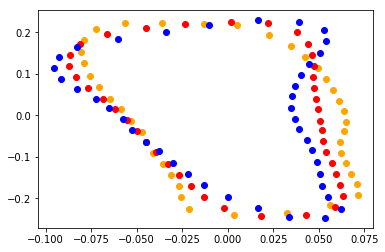

In [141]:
show_tooth_variations(2, 1)

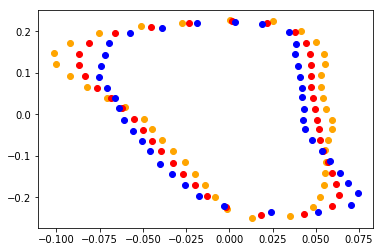

In [143]:
show_tooth_variations(3, 1)

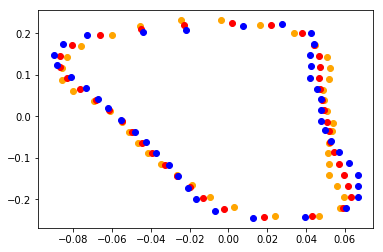

In [146]:
show_tooth_variations(4, 1)

In [24]:
def show_multiple_tooth_variations():
    
    plt.figure()
    hn = 4
    fig, ax = plt.subplots(figsize=(14, 4))

    for i in range(4):
        plt.subplot(1, hn, i+1)
        plt.xticks(())
        plt.yticks(())   
        show_tooth_variations(i, 1, False)
     
    plt.show()

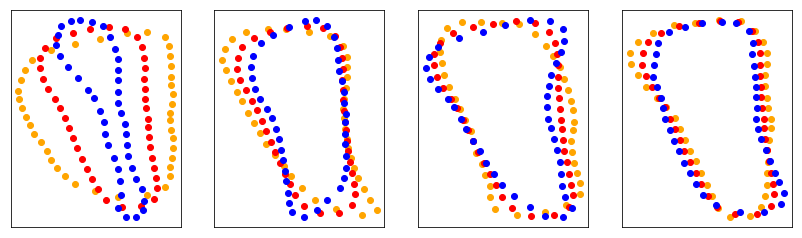

In [25]:
show_multiple_tooth_variations()